In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/cats-and-dogs-image-classification")

print("Path to dataset files:", path)

100%|██████████| 64.4M/64.4M [00:00<00:00, 209MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/cats-and-dogs-image-classification/versions/4


Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.
Classes: ['cats', 'dogs']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.5120 - loss: 13.2924 - val_accuracy: 0.4865 - val_loss: 9.2288
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5088 - loss: 11.3713 - val_accuracy: 0.4865 - val_loss: 4.3181
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5312 - loss: 8.5985 - val_accuracy: 0.5135 - val_loss: 4.9774
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5379 - loss: 4.4264 - val_accuracy: 0.5135 - val_loss: 1.7680
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4857 - loss: 2.2640 - val_accuracy: 0.5766 - val_loss: 0.6954
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5419 - loss: 1.4084 - val_accuracy: 0.4865 - val_loss: 0.6949
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5075 - loss: 0.8761 - val_accuracy: 0.5946 - val_loss: 0.6692
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5327 - loss: 0.6893 - val_accuracy: 0.4595 

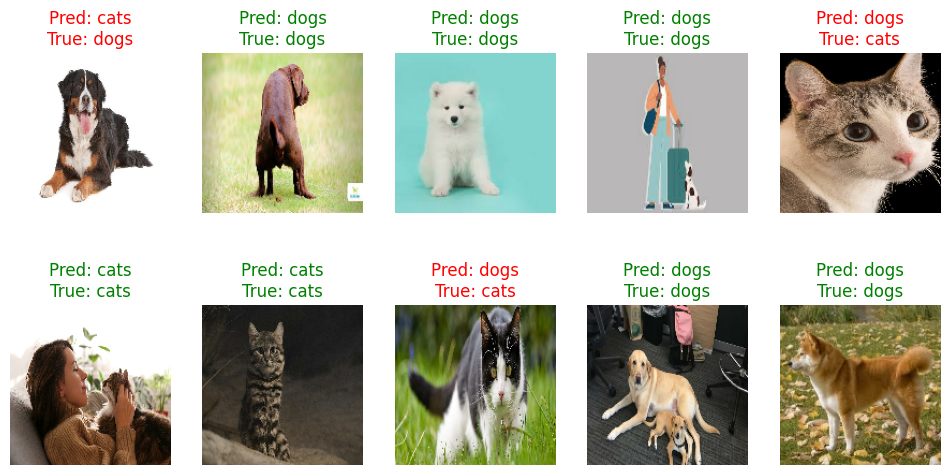

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Directories
train_dir = "/root/.cache/kagglehub/datasets/samuelcortinhas/cats-and-dogs-image-classification/versions/4/train"

img_size = (150, 150)
batch_size = 32

# Load dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build ANN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),  # normalize pixels
    layers.Flatten(),                                     # flatten image (150*150*3 = 67500 features)
    layers.Dense(512, activation='relu'),                 # fully connected
    layers.Dropout(0.5),                                  # prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')                 # binary classification
])

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

# Plot predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for images, labels in val_ds.take(1):   # one batch
    predictions = model.predict(images)
    for i in range(10):   # show first 10
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred = "dogs" if predictions[i] > 0.5 else "cats"
        true = class_names[labels[i]]

        color = "green" if pred == true else "red"
        plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
        plt.axis("off")
plt.show()
